In [1]:
import pathlib
import os
import glob
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import butter, lfilter
import math

In [2]:
def getPath():
    path = pathlib.Path().resolve()
    return path

In [3]:
def getFiles(path):
    # use glob to get all the csv files in the folder
    files = glob.glob(os.path.join(path, "*.csv"))
    return files

In [4]:
def overwriteCSV(csv_name):

    # Read the CSV file and replace semicolons with commas
    with open(csv_name, 'r', newline='', encoding='utf-8') as file:
        reader = csv.reader(file, delimiter=';')
        rows = [','.join(row) for row in reader]

    # Write the updated content back to the CSV file
    with open(csv_name, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter=',')
        for row in rows:
            writer.writerow(row.split(','))

    #print("Semicolons have been replaced with commas and the file has been overwritten.")

def setCSV(files):

    for file in files:
        csv_name = file.split("\\")[-1]
        if pd.read_csv(csv_name).shape[1] == 1:
            overwriteCSV(csv_name)

In [5]:
def getCoef():
    path = str.join('\\', getFiles(getPath())[0].split("\\")[:-2]) + "\\cal.xlsx"
    df = pd.read_excel(path)
    coefa1 = df["coef a"][0]
    coefa2 = df["coef a"][1]
    coefa3 = df["coef a"][2]
    coefb1 = df["coef b"][0]
    coefb2 = df["coef b"][1]
    coefb3 = df["coef b"][2]
    return coefa1, coefa2, coefa3, coefb1, coefb2, coefb3

In [6]:
def getCal(coefa1, coefa2, coefa3, coefb1, coefb2, coefb3, df):
    new = df
    new.iloc[:,0] = df.iloc[:,0] * coefa1 + coefb1
    new.iloc[:,1] = df.iloc[:,1] * coefa2 + coefb2
    new.iloc[:,2] = df.iloc[:,2] * coefa3 + coefb3
    sum_ = pd.concat([new.iloc[:, :3], new.iloc[:, :3].sum(axis=1), new.iloc[:, -1:]], axis=1)
    return sum_

In [7]:
def renamingCol(df):
    new = df
    new.columns = ["SA cel1 (g)", "SA cel2 (g)", "SA cel3 (g)", "SA Total (g)", "Time (linear)"]
    return new

In [8]:
def getStart(files, idx):
    start_hour = float(files[idx].split('\\')[-1][1:3])
    start_minute = float(files[idx].split('\\')[-1][3:5])
    start_sec = float(files[idx].split('\\')[-1][5:7])
    return start_hour, start_minute, start_sec

In [9]:
def getDiff(df):
    diff = abs(df.diff())
    diff.iloc[0] = 0
    return diff

In [10]:
def getCumsum(df):
    cumsum = df.cumsum()
    return cumsum

In [11]:
def getHours(df, start_hour, start_min, start_sec):
    diff_hours = getDiff(df.iloc[:, -1:])
    diff_hours.columns = ["Time (hour)"]
    cumsum_hours = getCumsum(diff_hours)
    hours = cumsum_hours/3600000 + start_hour + (start_min/60) + (start_sec/3600)
    hours = hours.astype(int)
    new = pd.concat([df, hours], axis=1)
    return new

In [12]:
def getMin(df, start_min, start_sec):
    diff_min = getDiff(df.iloc[:, -2:-1])
    diff_min.columns = ["Time (min)"]
    cumsum_min = getCumsum(diff_min)
    diff_hours = getDiff(df.iloc[:, -1:])
    cumsum_hours = getCumsum(diff_hours)
    cumsum_hours.columns = ["Time (min)"]
    minutes = cumsum_min/60000 + start_min + (start_sec/60)
    minutes = minutes - (cumsum_hours * 60)
    return pd.concat([df, minutes.astype(int)], axis=1)

In [13]:
def main():
    files = getFiles(getPath())
    setCSV(files)
    df = pd.DataFrame()
    for i, file in enumerate(files):
        temp1 = pd.read_csv(files[i]).iloc[:,:4].dropna().astype(float)
        coefa1, coefa2, coefa3, coefb1, coefb2, coefb3 = getCoef()
        temp2 = getCal(coefa1, coefa2, coefa3, coefb1, coefb2, coefb3, temp1)
        temp3 = renamingCol(temp2)
        start_hour, start_min, start_sec = getStart(files, i)
        temp4 = getHours(temp3, start_hour, start_min, start_sec)
        temp5 = getMin(temp4, start_min, start_sec)
        df = pd.concat([df, temp5], axis=0)
    return df.reset_index(drop=True)

In [14]:
df_raw = main()
df_raw

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18456\3055814788.py:20: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  if pd.read_csv(csv_name).shape[1] == 1:
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18456\3055814788.py:20: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  if pd.read_csv(csv_name).shape[1] == 1:
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18456\641856221.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  temp1 = pd.read_csv(files[i]).iloc[:,:4].dropna().astype(float)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18456\641856221.py:6: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  temp1 = pd.read_csv(files[i]).iloc[:,:4].dropna().astype(float)


,SA cel1 (g),SA cel2 (g),SA cel3 (g),SA Total (g),Time (linear),Time (hour),Time (min)
0,2.611833,2.185429,1.403785,6.201047,385.0,9,35
1,4.508485,-0.095357,-1.229694,3.183434,397.0,9,35
2,2.611833,-1.754110,-1.027119,-0.169395,408.0,9,35
3,-1.181471,-0.924733,-1.432269,-3.538473,420.0,9,35
4,0.504442,0.941364,0.390908,1.836714,442.0,9,35
...,...,...,...,...,...,...,...
2762368,1552.597962,2035.194540,2531.974674,6119.767176,91992175.0,11,12
2762369,1559.763091,2072.309138,2570.869136,6202.941364,91992209.0,11,12
2762370,1520.987096,2086.823226,2538.457085,6146.267406,91992243.0,11,12
2762371,1556.602005,2041.622208,2540.482838,6138.707050,91992276.0,11,12


In [15]:
def nextPower(num, base):
    i = 1
    while i < num: i *= base
    return i

def setParameters(df, total_time):
    N = df.shape[0]  # number of sample points
    n_fft = nextPower(N, 2) # fft window size is the next power of two of N
    Fs = N / total_time # sampling frequence = number of samples / total time in seconds
    T = 1/Fs # sample spacing
    return n_fft, Fs

def getFft(df, total_time):
    #y = df
    #mean_removed = np.ones_like(y) * np.mean(y) # removing the mean of the signal
    #y = y - mean_removed 
    #x = np.linspace(0, N*T, N) # the interval
    n_fft, Fs = setParameters(df, total_time)
    yf = np.abs(np.fft.fft(df, n=n_fft))
    xf = np.arange(0, Fs, Fs/n_fft)
    
    return xf, yf

def getFilters(df, total_time, order):
    n_fft, Fs = setParameters(df, total_time)   
    nyq = 0.5 * Fs
    lowcut = 0.05/nyq
    highcut = 8/nyq
    [A_bp, B_bp] = butter(order, [(0.1/nyq), (8/nyq)], btype='band')
    [A_hp, B_hp] = butter(order, lowcut, btype='high')
    [A_lp, B_lp] = butter(order, highcut, btype='low')
    df_bp = lfilter(A_bp, B_bp, df)
    df_hp = lfilter(A_hp, B_hp, df)
    df_lp = lfilter(A_lp, B_lp, df)
    return df_bp, df_hp, df_lp

In [16]:
def plotFft(df, total_time, y_lim, title):
    xf, yf = getFft(df, total_time)  
    
    y_bp, y_hp, y_lp = getFilters(df, total_time, 4)
    
    xf_bp, yf_bp = getFft(y_bp, total_time)
    xf_hp, yf_hp = getFft(y_hp, total_time)
    xf_lp, yf_lp = getFft(y_lp, total_time)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
    axs[0, 0].plot(xf[:xf.shape[0]//2], yf[:yf.shape[0]//2], lw=1.0, c='b')
    axs[0, 0].axis([-1, 16, 0, y_lim])
    axs[0, 0].set_title(title + " FFT", fontsize = 16, fontweight = "bold")
    axs[0, 0].set_ylabel('FFT magnitude (power)')
    axs[0, 0].grid()
    axs[1, 0].plot(xf_bp[:xf_bp.shape[0]//2], yf_bp[:yf_bp.shape[0]//2], lw=1.0, c='b')
    axs[1, 0].axis([-1, 16, 0, y_lim])
    axs[1, 0].set_title("0.1-8hz Bandpass FFT", fontsize = 16, fontweight = "bold")
    axs[1, 0].set_ylabel('FFT magnitude (power)')
    axs[1, 0].set_xlabel('Frequency (Hz)')
    axs[1, 0].grid()
    axs[0, 1].plot(xf_lp[:xf_lp.shape[0]//2], yf_lp[:yf_lp.shape[0]//2], lw=1.0, c='b')
    axs[0, 1].axis([-1, 16, 0, y_lim])
    axs[0, 1].set_title("8hz Lowpass FFT", fontsize = 16, fontweight = "bold")
    axs[0, 1].grid()
    axs[1, 1].plot(xf_hp[:xf_hp.shape[0]//2], yf_hp[:yf_hp.shape[0]//2], lw=1.0, c='b')
    axs[1, 1].axis([-1, 16, 0, y_lim])
    axs[1, 1].set_title("0.05hz Highpass FFT", fontsize = 16, fontweight = "bold")
    axs[1, 1].set_xlabel('Frequency (Hz)')
    axs[1, 1].grid()
    
    '''
    plt.figure()
    plt.plot(xf[:xf.shape[0]//2], np.abs(yf[:yf.shape[0]//2]), lw=1.0, c='b')
    plt.title('Analytic FFT plot', fontsize = 16, fontweight = "bold")
    plt.ylabel('FFT magnitude (power)')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    '''
    
    return yf, xf

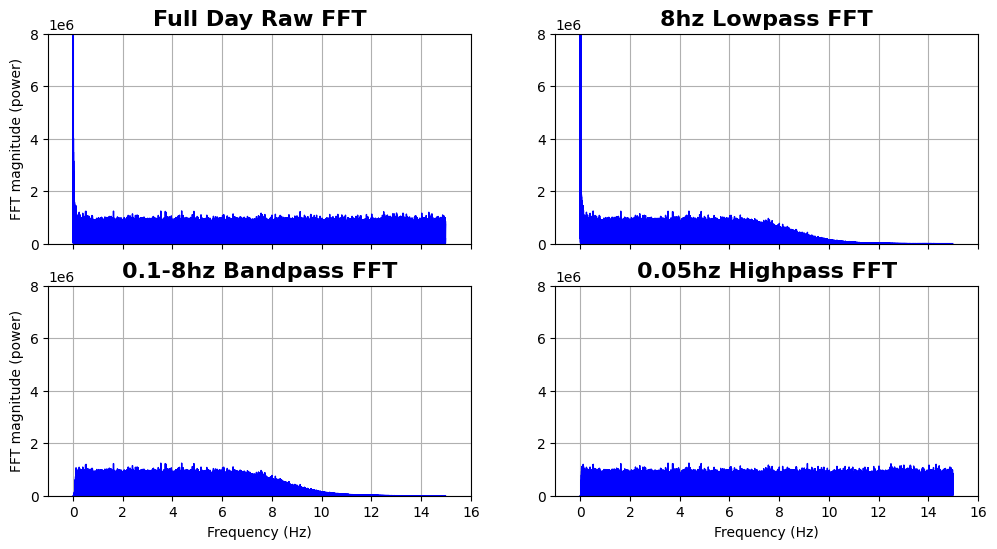

In [17]:
yf, xf = plotFft(df_raw["SA Total (g)"], df_raw[getDiff(df_raw["Time (min)"]) != 0].shape[0] * 60, 8e6, "Full Day Raw")

<Axes: xlabel='Time (hour)', ylabel='SA cel1 (g)'>

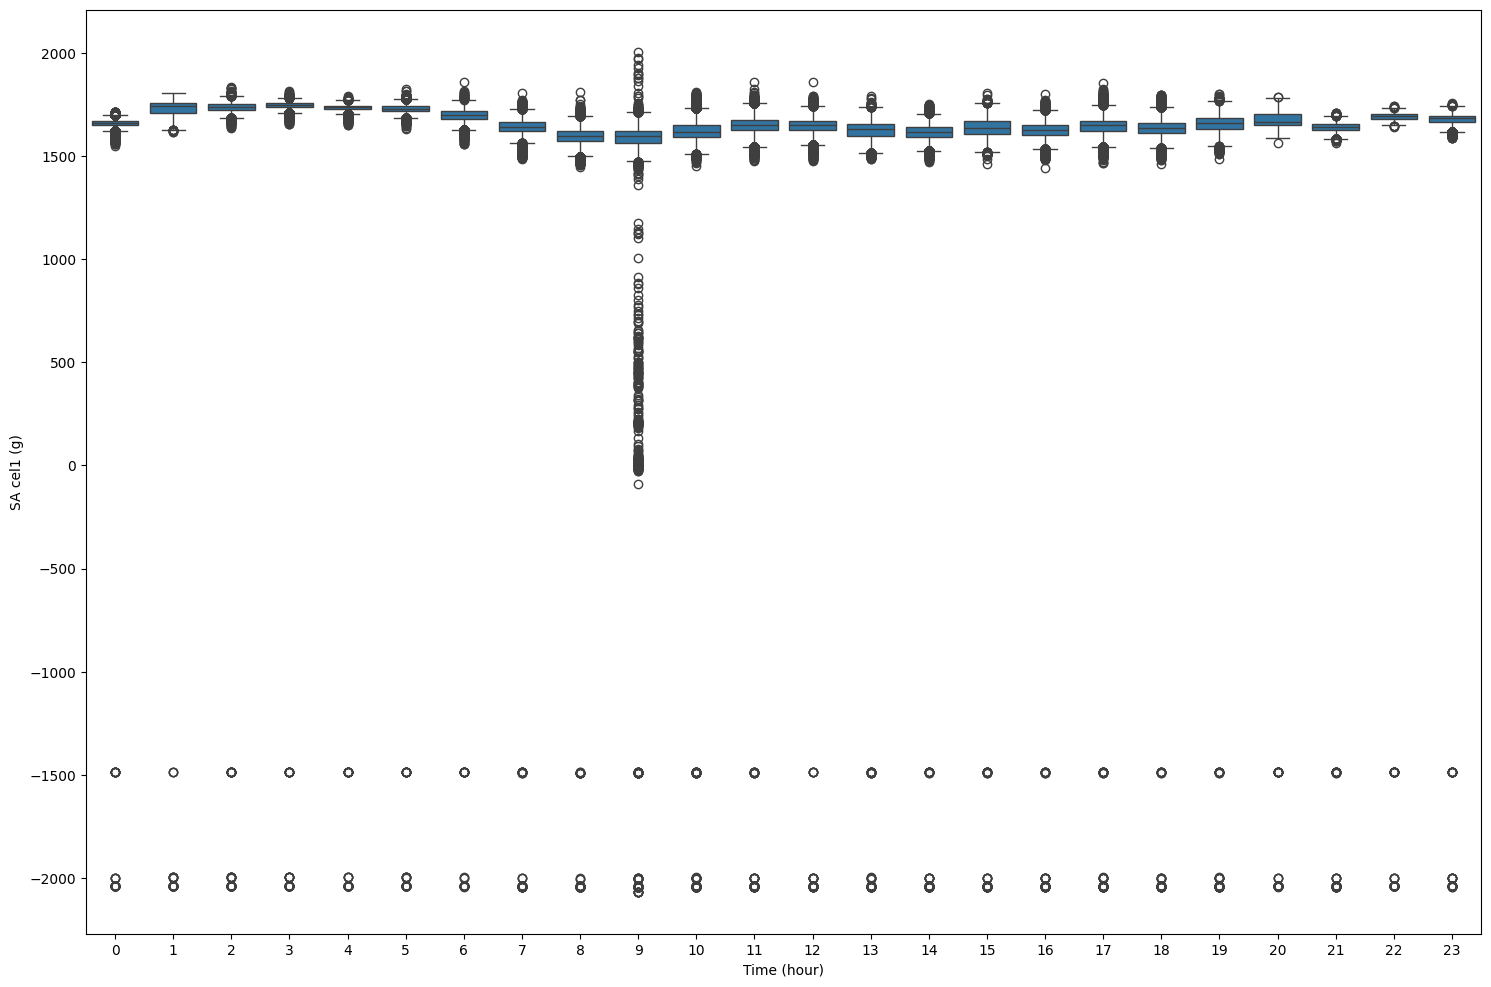

In [18]:
plt.figure(figsize=(18, 12))

sns.boxplot(data=df_raw, x="Time (hour)", y="SA cel1 (g)")

In [19]:
infLim1 = df_raw["SA cel1 (g)"].mean() - 2 * df_raw["SA cel1 (g)"].std()
infLim2 = df_raw["SA cel2 (g)"].mean() - 2 * df_raw["SA cel2 (g)"].std()
infLim3 = df_raw["SA cel3 (g)"].mean() - 2 * df_raw["SA cel3 (g)"].std()
infLim1, infLim2, infLim3

(1370.2931463234188, 1699.0265236671705, 2075.3758816540444)

In [20]:
df_outliers = df_raw[(df_raw["SA cel1 (g)"] > infLim1) & (df_raw["SA cel2 (g)"] > infLim2) & (df_raw["SA cel3 (g)"] > infLim3)].reset_index(drop=True)
df_outliers = df_outliers.drop(columns=["SA cel1 (g)", "SA cel2 (g)", "SA cel3 (g)", "Time (linear)"])

<Axes: xlabel='Time (hour)', ylabel='SA Total (g)'>

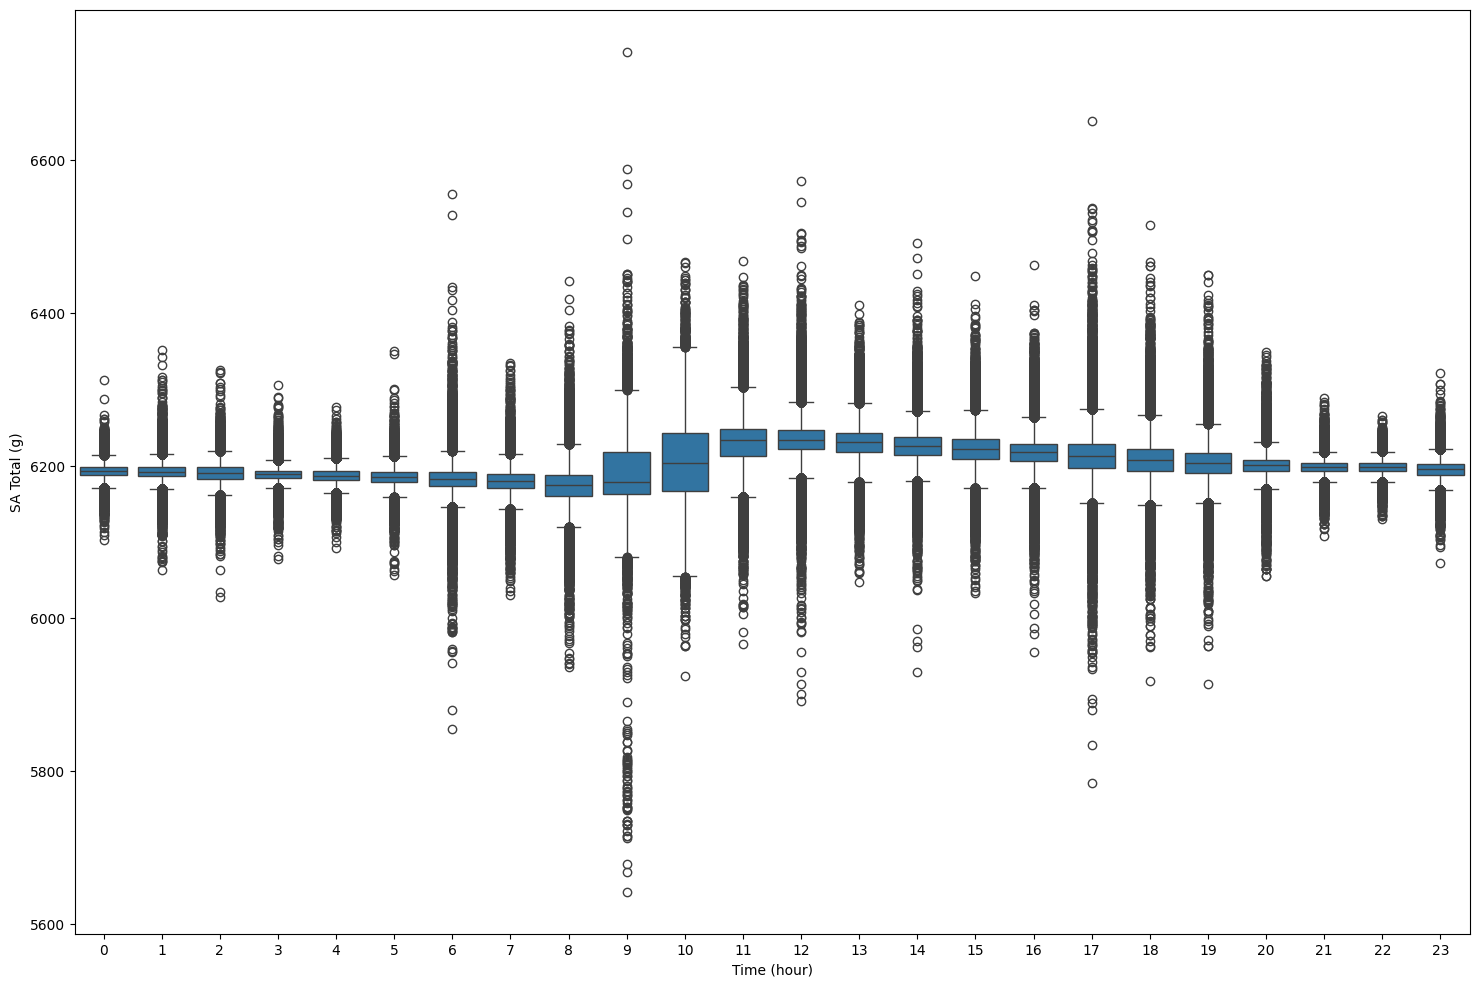

In [21]:
plt.figure(figsize=(18, 12))

sns.boxplot(data=df_outliers, x="Time (hour)", y="SA Total (g)")

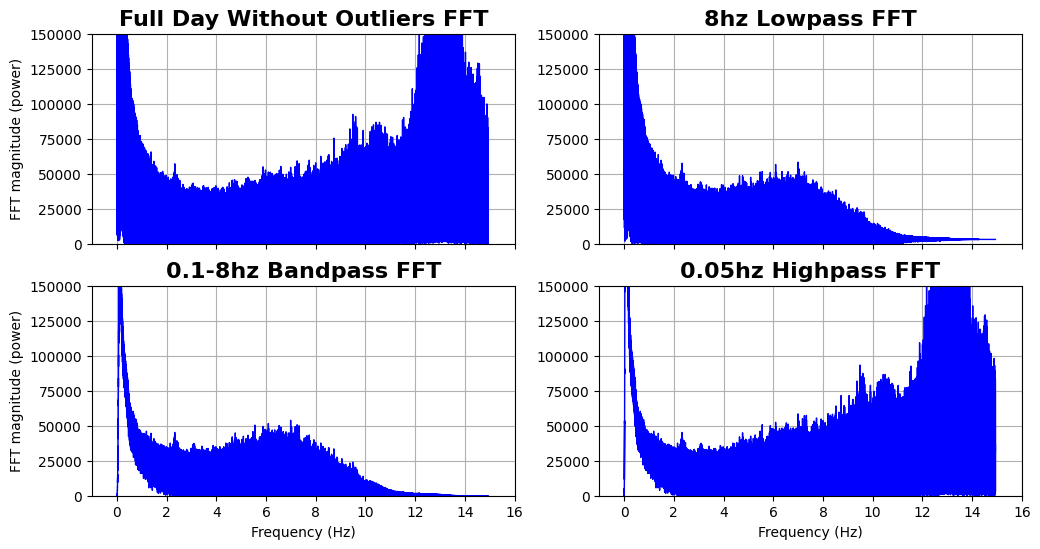

In [22]:
yf_outliers, xf_outliers = plotFft(df_outliers["SA Total (g)"], df_outliers[getDiff(df_outliers["Time (min)"]) != 0].shape[0] * 60, 150000, "Full Day Without Outliers")

In [23]:
'''
cut02 = df_outliers[(df_outliers["Time (hour)"] == 2)]
cut02_50 = df_outliers[(df_outliers["Time (hour)"] == 2) & (df_outliers["Time (min)"] == 50)]
cut14 = df_outliers[(df_outliers["Time (hour)"] == 14)]
cut14_50 = df_outliers[(df_outliers["Time (hour)"] == 14) & (df_outliers["Time (min)"] == 50)]
'''

'\ncut02 = df_outliers[(df_outliers["Time (hour)"] == 2)]\ncut02_50 = df_outliers[(df_outliers["Time (hour)"] == 2) & (df_outliers["Time (min)"] == 50)]\ncut14 = df_outliers[(df_outliers["Time (hour)"] == 14)]\ncut14_50 = df_outliers[(df_outliers["Time (hour)"] == 14) & (df_outliers["Time (min)"] == 50)]\n'

In [24]:
#plotFft(cut02["SA Total (g)"], 3600, 6000, "02:00 - 02:59")

In [25]:
#plotFft(cut02_50["SA Total (g)"], 60, 1000, "02:50 - 02:51")

In [26]:
#plotFft(cut14["SA Total (g)"], 3600, 6000, "14:00 - 14:59")

In [27]:
#plotFft(cut14_50["SA Total (g)"], 60, 1000, "14:50 - 14:51")

In [28]:
def getSA_fft(cut, total_time):
    xf, yf = getFft(cut, total_time)
    return yf[(xf > 3.5) & (xf < 6)].mean()

def getCuts(df, idx_min):
    mean = []
    sum_ = []
    std = []
    fft = []
    time_min = []
    time_hour = []
    temp = 0
    
    for i, i_min in enumerate(idx_min):
        cut_min = df.iloc[temp:i_min, 0]
        diff = abs(cut_min.diff())
        mean.append(diff.mean())
        sum_.append(diff.sum())
        std.append(diff.std())
        fft.append(getSA_fft(cut_min, 60))
        time_hour.append(df.iloc[temp:i_min, 1].mean())
        time_min.append(df.iloc[temp:i_min, 2].mean())
        temp = i_min

    return pd.concat([pd.DataFrame({"Mean SA (g)" : mean}), pd.DataFrame({"Sum SA (g)" : sum_}), pd.DataFrame({"Std (g)" : std}),
                     pd.DataFrame({"3.5-6 Hz FFT (power)" : fft}), pd.DataFrame({"Time (hour)" : time_hour}), pd.DataFrame({"Time (minute)" : time_min})], axis=1)

In [29]:
def getIdx(df):
    idx_min = df[getDiff(df["Time (min)"]) != 0].index
    return idx_min

def getGhost(df):
    min_mean = df["Mean SA (g)"].min()
    min_sum = df["Sum SA (g)"].min()
    return min_mean, min_sum

def setGhost(df, ghost_mean, ghost_sum):
    df["Mean SA (g)"] = df["Mean SA (g)"] - ghost_mean
    df["Sum SA (g)"] = df["Sum SA (g)"] - ghost_sum
    return df

def main2(df):
    idx_min = getIdx(df)
    
    df_cuts = getCuts(df, idx_min)
    
    ghost_mean, ghost_sum = getGhost(df_cuts)
    
    df_final = setGhost(df_cuts, ghost_mean, ghost_sum)
    
    return df_final, ghost_mean, ghost_sum

In [30]:
df_final, ghost_mean, ghost_sum = main2(df_outliers)

In [31]:
df_final

,Mean SA (g),Sum SA (g),Std (g),3.5-6 Hz FFT (power),Time (hour),Time (minute)
0,39.620852,61437.938549,54.911353,6745.929764,9.0,39.0
1,31.154221,61894.395464,29.424073,8835.807659,9.0,40.0
2,50.875400,98521.664852,60.070478,8885.618796,9.0,41.0
3,29.049410,57850.257427,25.016822,8729.998857,9.0,42.0
4,37.206714,73597.032461,34.948349,8840.806743,9.0,43.0
...,...,...,...,...,...,...
1528,16.765599,33870.707826,15.180905,8431.201564,11.0,7.0
1529,19.319964,38370.630024,18.703132,8355.403395,11.0,8.0
1530,16.093661,32740.601762,14.591546,8347.804978,11.0,9.0
1531,24.237115,47379.477424,28.023601,8363.655704,11.0,10.0


In [32]:
ghost_mean, ghost_sum

(3.247905523836424, 2093.560116904373)

In [33]:
# determining the name of the file
file1 = "df_final.xlsx"

# saving the file
pd.DataFrame(df_final).to_excel(file1)
print("Dataframes salvos com sucesso em arquivo xlsx: ", file1)

Dataframes salvos com sucesso em arquivo xlsx:  df_final.xlsx


In [34]:
df_outliers[(df_outliers["Time (hour)"] == 11) & (df_outliers["Time (min)"] == 59)]

,SA Total (g),Time (hour),Time (min)
256967,6259.930077,11,59
256968,6213.499287,11,59
256969,6241.754098,11,59
256970,6275.187347,11,59
256971,6196.623869,11,59
...,...,...,...
258489,6264.655639,11,59
258490,6246.367705,11,59
258491,6344.861585,11,59
258492,6129.577292,11,59


In [35]:
idx_min = getIdx(df_outliers)
idx_min[idx_min == 186803], idx_min[idx_min == 186842]

(Index([], dtype='int64'), Index([], dtype='int64'))